https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from src.preprocessing import PreprocessDataTrainTestSplit, PreprocessDataTSCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import  StandardScaler

In [2]:
root_path = Path(os.getcwd())
data_path = root_path.joinpath("Macro1.csv")

In [3]:
preprocess_train_test = PreprocessDataTrainTestSplit(data_path=data_path, test_size=0.3)
train_df, test_df = preprocess_train_test.process()

X_train = train_df.drop('INDPRO', axis=1).values
y_train = train_df['INDPRO'].values

X_test = test_df.drop('INDPRO', axis=1).values
y_test = test_df['INDPRO'].values

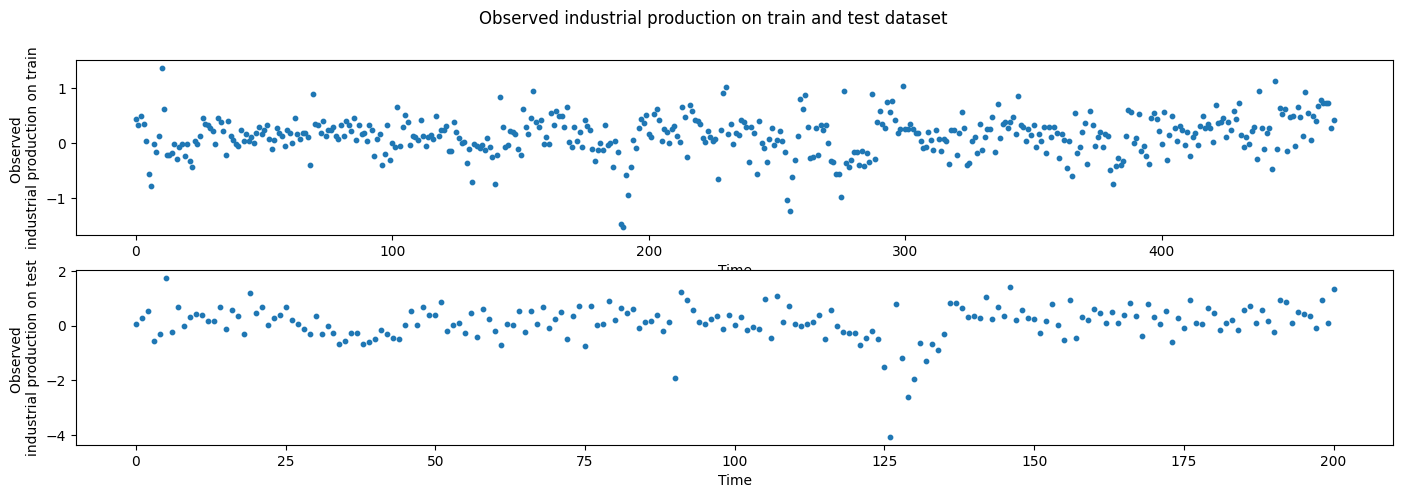

In [4]:
plt.figure(figsize=(17,5))
plt.subplot(2, 1, 1)
plt.scatter(range(len(y_train)), y_train, marker='o', s=10, label="True label")
plt.xlabel('Time')
plt.ylabel("Observed \nindustrial production on train")

plt.subplot(2, 1, 2)
plt.scatter(range(len(y_test)), y_test, marker='o', s=10, label="True label")
plt.xlabel('Time')
plt.ylabel("Observed \nindustrial production on test")

plt.suptitle("Observed industrial production on train and test dataset")
plt.show()

# No cross-validation

## Linear Regression

In [5]:
LR = LinearRegression()
LR.fit(X_train, y_train)
y_pred_train = LR.predict(X_train)
y_pred_test = LR.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Train R2: {}".format(r2_train))
print("Test R2: {}".format(r2_test))
print("Train MSE: {}".format(mse_train))
print("Test MSE: {}".format(mse_test))

Train R2: 0.9976704793640705
Test R2: -7.902876377304337e+17
Train MSE: 0.00030343290990255436
Test MSE: 3.279865243108579e+17


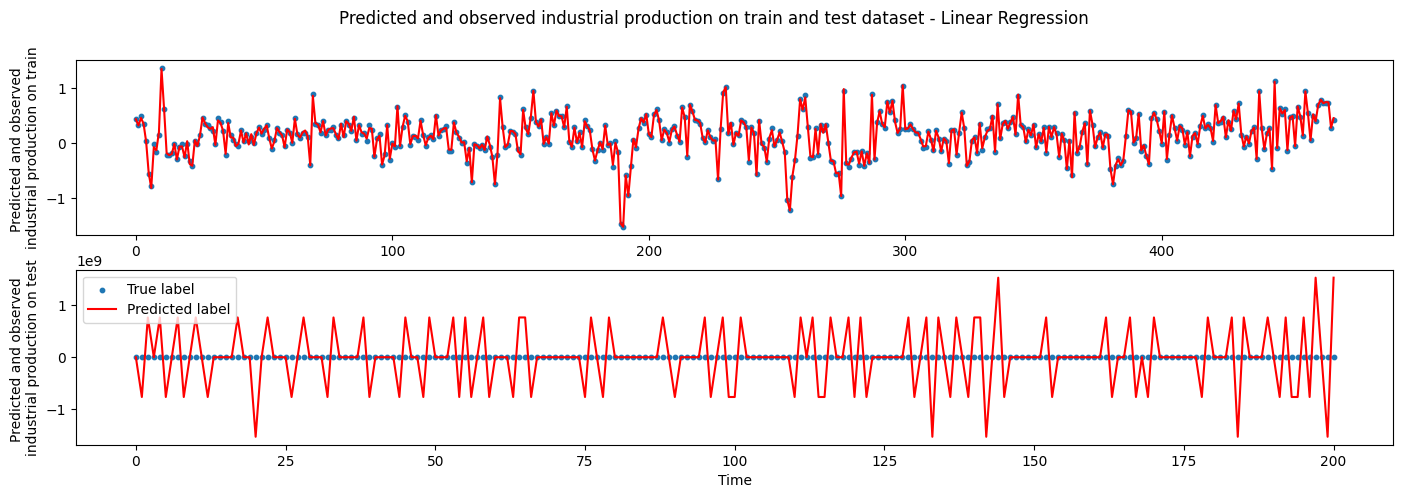

In [6]:
plt.figure(figsize=(17,5))
plt.subplot(2, 1, 1)
plt.scatter(range(len(y_train)), y_train, marker='o', s=10, label="True label")
plt.plot(y_pred_train, color='red', label="Predicted label")
plt.ylabel("Predicted and observed \nindustrial production on train")

plt.subplot(2, 1, 2)
plt.scatter(range(len(y_test)), y_test, marker='o', s=10, label="True label")
plt.plot(y_pred_test, color='red', label="Predicted label")
plt.xlabel('Time')
plt.ylabel("Predicted and observed \nindustrial production on test")

plt.suptitle("Predicted and observed industrial production on train and test dataset - Linear Regression")
plt.legend()
plt.show()

## Lasso Regression

In [7]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Train R2: {}".format(r2_train))
print("Test R2: {}".format(r2_test))
print("Train MSE: {}".format(mse_train))
print("Test MSE: {}".format(mse_test))

Train R2: 0.0
Test R2: -0.0009672476039939149
Train MSE: 0.13025551489973708
Test MSE: 0.41542313559841354


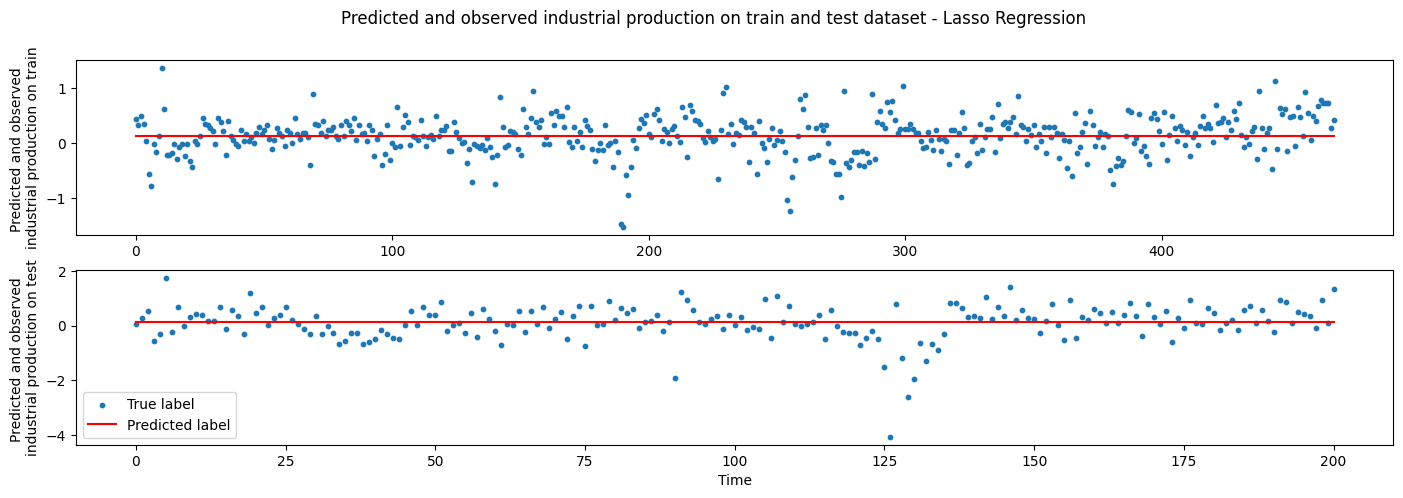

In [8]:
plt.figure(figsize=(17,5))
plt.subplot(2, 1, 1)
plt.scatter(range(len(y_train)), y_train, marker='o', s=10, label="True label")
plt.plot(y_pred_train, color='red', label="Predicted label")
plt.ylabel("Predicted and observed \nindustrial production on train")

plt.subplot(2, 1, 2)
plt.scatter(range(len(y_test)), y_test, marker='o', s=10, label="True label")
plt.plot(y_pred_test, color='red', label="Predicted label")
plt.xlabel('Time')
plt.ylabel("Predicted and observed \nindustrial production on test")

plt.suptitle("Predicted and observed industrial production on train and test dataset - Lasso Regression")
plt.legend()
plt.show()

# With cross validation

In [9]:
preprocess_cv = PreprocessDataTSCV(data_path=data_path)
df = preprocess_cv.process()

X = df.drop('INDPRO', axis=1).values
y = df['INDPRO'].values

## Linear Regression

Train R2: 0.9997644021104198
Train MSE: 1.8140208208420895e-05
Val R2: -4.1770551373027045
Val MSE: 0.7631025422757112


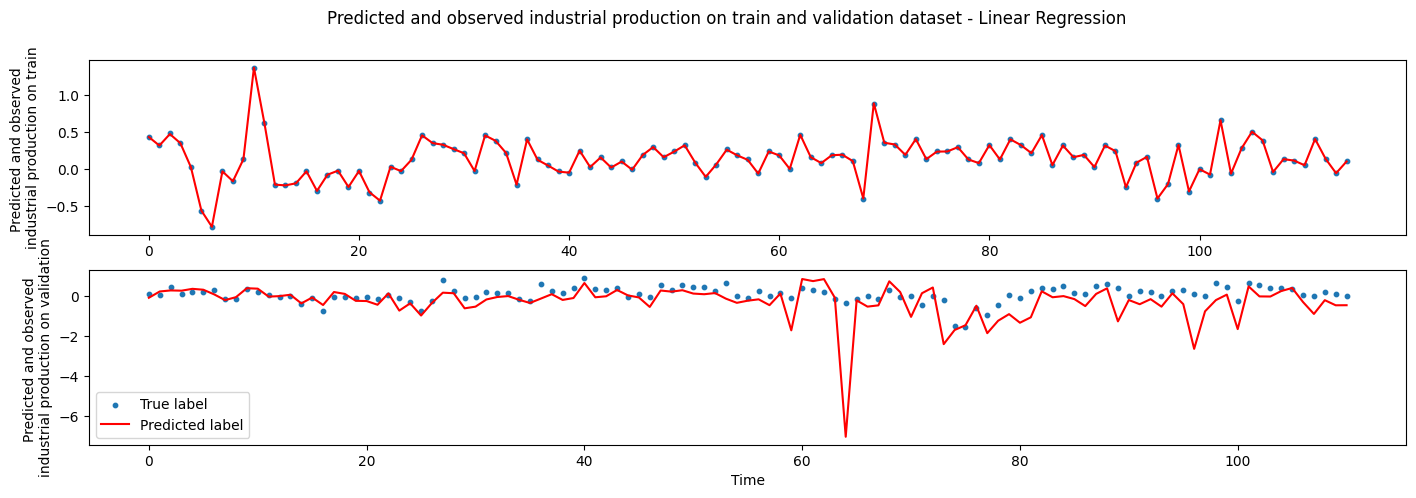

Train R2: 0.9979766103642229
Train MSE: 0.00022624979683625503
Val R2: 0.9877821587957116
Val MSE: 0.002141350976975806


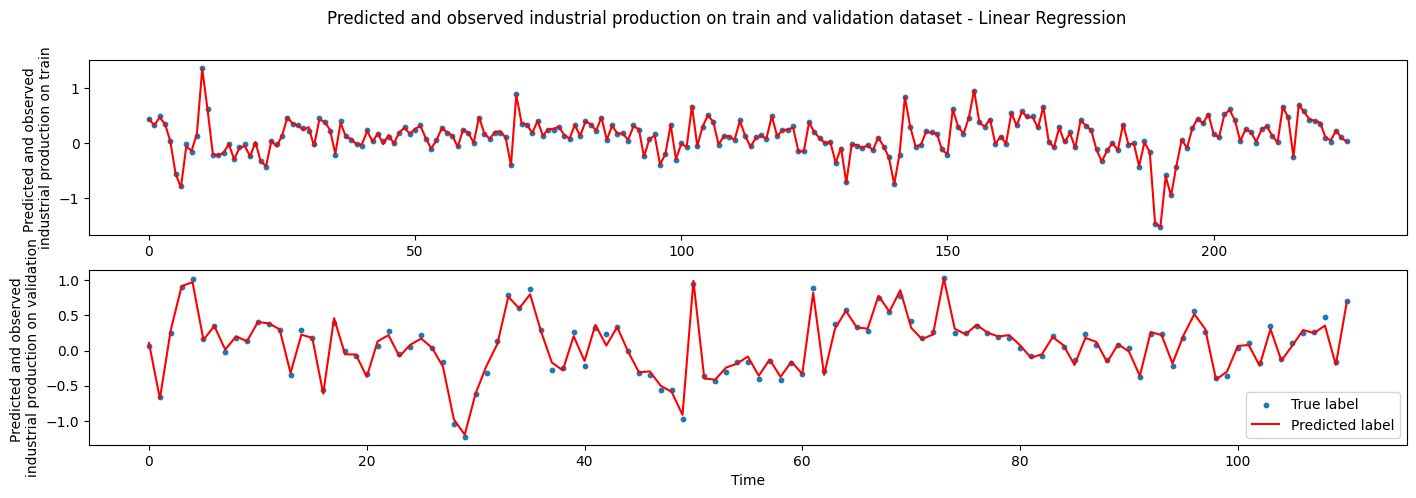

Train R2: 0.997822010479234
Train MSE: 0.0002898495196641934
Val R2: 0.988423891977778
Val MSE: 0.0012337864045767085


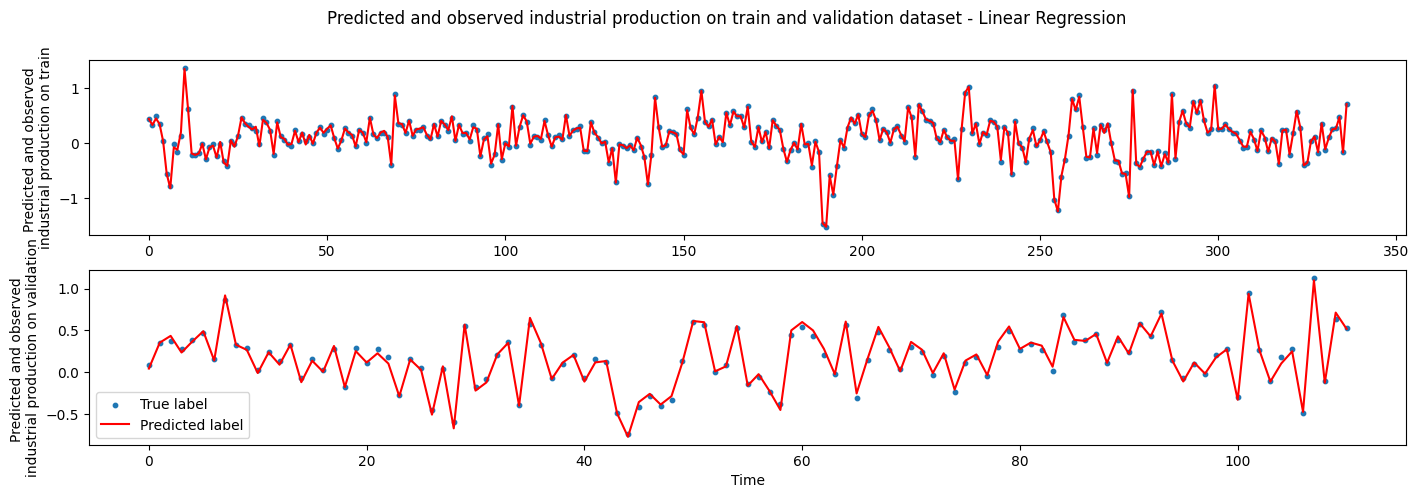

Train R2: 0.9964486428110888
Train MSE: 0.0004515412885114552
Val R2: -4.136001920091488e+16
Val MSE: 8223784287746219.0


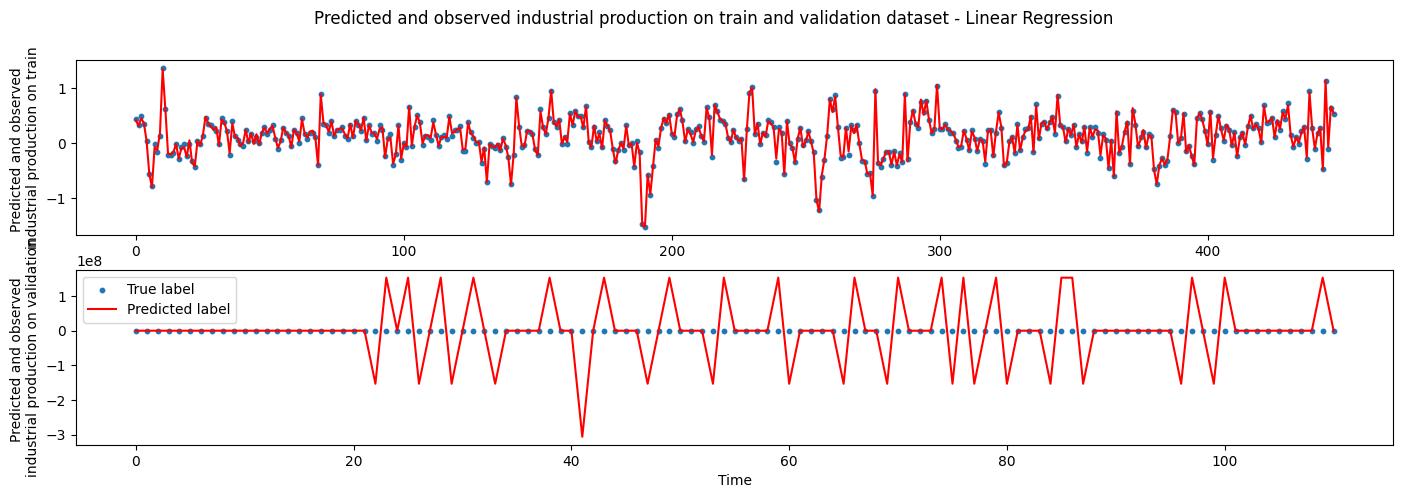

Train R2: 0.9983979024816824
Train MSE: 0.00022791273760600634
Val R2: 0.979540894919993
Val MSE: 0.011944052976384824


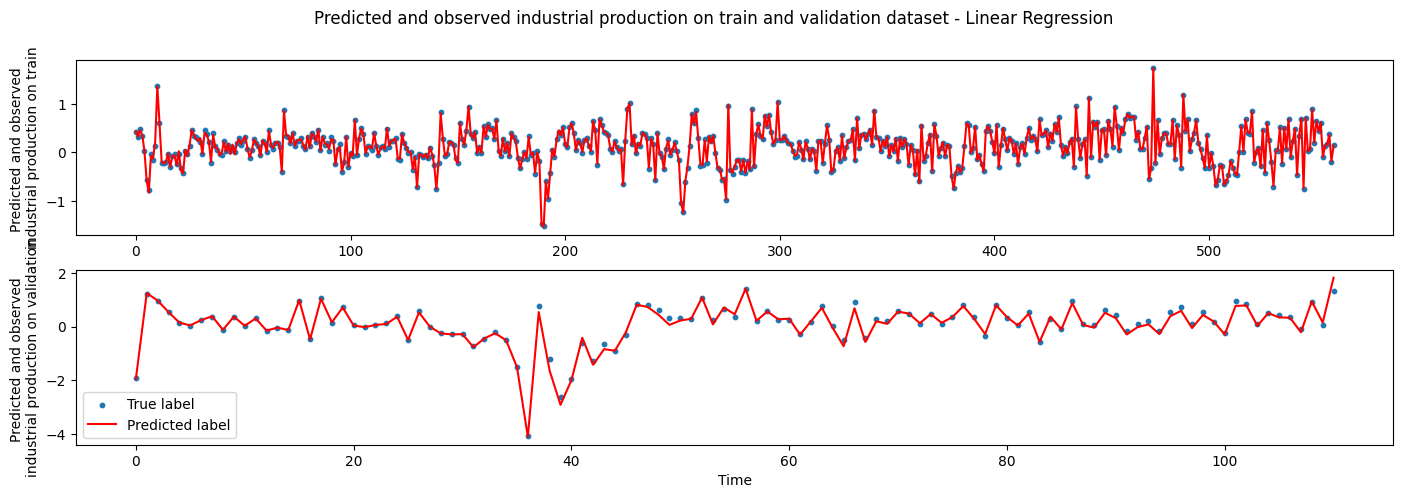

Average MSE - train: 0.00024273871016526616
Average R2 - train: 0.9980819136493295
Average MSE - validation: 1644756857549244.0
Average R2 - validation: -8272003840182976.0


In [18]:
LR = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
list_mse_train = []
list_r2_train = []
list_mse_val = []
list_r2_val = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X[train_index, :], X[val_index, :]
    y_train, y_val = y[train_index], y[val_index]

    scaler = StandardScaler()
    X_train_transform = scaler.fit_transform(X_train)
    X_val_transform = scaler.transform(X_val)
    
    LR.fit(X_train_transform, y_train)
    y_pred_train = LR.predict(X_train_transform)
    y_pred_val = LR.predict(X_val_transform)

    r2_train = r2_score(y_train, y_pred_train)
    r2_val = r2_score(y_val, y_pred_val)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_val = mean_squared_error(y_val, y_pred_val)

    list_mse_train.append(mse_train)
    list_r2_train.append(r2_train)
    list_mse_val.append(mse_val)
    list_r2_val.append(r2_val)

    print("Train R2: {}".format(r2_train))
    print("Train MSE: {}".format(mse_train))
    print("Val R2: {}".format(r2_val))
    print("Val MSE: {}".format(mse_val))

    plt.figure(figsize=(17,5))
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(y_train)), y_train, marker='o', s=10, label="True label")
    plt.plot(y_pred_train, color='red', label="Predicted label")
    plt.ylabel("Predicted and observed \nindustrial production on train")

    plt.subplot(2, 1, 2)
    plt.scatter(range(len(y_val)), y_val, marker='o', s=10, label="True label")
    plt.plot(y_pred_val, color='red', label="Predicted label")
    plt.xlabel('Time')
    plt.ylabel("Predicted and observed \nindustrial production on validation")

    plt.suptitle("Predicted and observed industrial production on train and validation dataset - Linear Regression")
    plt.legend()
    plt.show()

print("Average MSE - train: {}".format(sum(list_mse_train)/len(list_mse_train)))
print("Average R2 - train: {}".format(sum(list_r2_train)/len(list_r2_train)))
print("Average MSE - validation: {}".format(sum(list_mse_val)/len(list_mse_val)))
print("Average R2 - validation: {}".format(sum(list_r2_val)/len(list_r2_val)))